In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from celluloid import Camera
from IPython.display import HTML
import jax.numpy as jnp
import jax.scipy as jsc
from jax.nn import softmax
plt.rc('figure', figsize=(10.0, 3.0), dpi=120, facecolor="w")
np.random.seed(222)

def kde(x, data, h):
    return jnp.mean(jsc.stats.norm.pdf(x.reshape(-1,1),loc=data,scale=h), axis=1)

def kde_hist(events, bins, bandwidth=None, density=False):
      """
      Args:
              events: (jax array-like) data to filter.

              bins: (jax array-like) intervals to calculate counts.

              bandwidth: (float) value that specifies the width of the individual
              distributions (kernels) whose cdfs are averaged over each bin. Defaults
              to Scott's rule -- the same as the scipy implementation of kde.

              density: (bool) whether or not to normalize the histogram to unit area.
      Returns:
              binned counts, calculated by kde!
      """
      bandwidth = bandwidth or events.shape[-1]**-.25 # Scott's rule

      edge_hi = bins[1:] # ending bin edges ||<-
      edge_lo = bins[:-1] # starting bin edges ->||

      # get cumulative counts (area under kde) for each set of bin edges
      cdf_up = jsc.stats.norm.cdf(edge_hi.reshape(-1,1),loc = events, scale = bandwidth)
      cdf_dn = jsc.stats.norm.cdf(edge_lo.reshape(-1,1),loc = events, scale = bandwidth)
      # sum kde contributions in each bin
      counts = (cdf_up - cdf_dn).sum(axis=1) 

      if density: # normalize by bin width and counts for total area = 1
            db = jnp.array(jnp.diff(bins), float) # bin spacing
            return counts/db/counts.sum(axis=0)

      return counts

In [2]:
softmax(jnp.array([1,2,3,4]))

DeviceArray([0.0320586 , 0.08714432, 0.23688284, 0.6439143 ], dtype=float32)

In [ ]:
# This presentation is a Jupyter notebook! (thanks to https://github.com/damianavila/RISE )
2*2

# Physics analysis as a differentiable program
Lukas Heinrich, **Nathan Simpson** <- me

<figure style="display:flex; padding-right: 20px; padding left: 20px;">
    <img src="assets/cern.jpg" width="140" />
    <img src="assets/lu.png" width="140" /> 
    <img src="assets/gradhep.png" width="140" />
    <img src="assets/insights.jpg" width="210" /> 
    <img src="assets/eu.png" width="210" />  
<figure/>

<img src="assets/anaflow.png" width="70%"/>

**A typical analysis:** 

<span style="color:blue">data</span>  →      <span style="color:maroon">cutflow</span> → <span style="color:green">observable</span> → <span style="color:lightblue">model</span> → <span style="color:teal">test statistic</span> → <span style="color:orange">hypothesis test</span> → <span style="color:darkyellow">*limits* (p-values)</span>

<img src="assets/free.png" width="70%"/>

<span style="color:orange">**Free parameters:**</span> cut values, parameters of a multivariate observable

*Can we optimize them?*

**Sure we can!** 

Here's what we might do:

- *Cuts:*  grid search of <span style="color:orange">cut positions</span>
    - Objective: <span style="color:blue">maximize approximate median significance $Z_{A}^{\left(\sigma_{b}=0\right)}=\sqrt{2((s+b) \ln (1+s / b)-s)}$</span>
    
    

- *Observable (e.g. neural network):* train parameters <span style="color:orange">$\phi$</span> via gradient descent
    - Objective: <span style="color:blue">minimize binary cross entropy (signal vs background)</span>

Why do the methods and objectives differ if they're in the same pipeline?

**They don't have to!**

- Sigmoid cut optimized wrt $Z_A$ using gradient descent: ([notebook from Alex Held](https://mybinder.org/v2/gh/alexander-held/differentiable-analysis-example/master?filepath=Significance_optimization.ipynb))

<img src="assets/cut.gif" width="50%"/>

- Using $1/Z_A$ as a loss function: https://arxiv.org/abs/1806.00322

One could then imagine a *jointly-optimized pipeline* with respect to a single objective, trained using <span style="color:purple">gradient descent</span>.

This raises an important question:

- <span style="color:green">**What should that objective be?**</span>

## Picking the right objective

Insights from Sec 3.1, [Deep Learning and its Application to LHC Physics](https://arxiv.org/abs/1806.11484):

> <span style="color:blue">"tools are often optimized for performance on a particular task that is several steps removed from the ultimate physical goal of searching for a new particle or testing a new
physical theory"</span>

## Picking the right objective

Insights from Sec 3.1, [Deep Learning and its Application to LHC Physics](https://arxiv.org/abs/1806.11484):

> <span style="color:red">"considerations are further complicated by the fact that the sensitivity to high-level physics questions must account for systematic uncertainties, which involve a nonlinear
trade-off between the typical machine learning performance metrics and the systematic uncertainty estimates."</span>

We want:
- a goal that is directly related to our physics objective
- to take into account the <span style="color:teal">*full profile likelihood*</span> in order to be robust to systematic variations of nusiance parameters

*But don't we already have this?*

<img src="assets/anaflowgrad.png" width="70%"/>

We can optimize our analysis *end-to-end* with respect to the actual significance... if we can <span style="color:purple">evaluate its gradient</span>.

## Differentiable analysis:

<span style="color:teal">**Analysis with free parameters $\varphi$ that can be optimized end-to-end using gradient-based methods.**

$$\varphi' = \varphi - \frac{\partial \, \mathsf{objective} }{\partial \, \mathsf{\varphi}}\times  \mathsf{learning~rate} $$</span>


Due to the chain rule, *every step in-between the objective and the parameters must also be differentiable.*

e.g. $$\frac{\partial \, \mathsf{objective} }{\partial \, \mathsf{\varphi}} = \frac{\partial \, \mathsf{objective} }{\partial \, \mathsf{likelihood}} \times \frac{\partial \, \mathsf{likelihood} }{\partial \, \mathsf{model~parameters}}\times\frac{\partial \, \mathsf{model~parameters} }{\partial \, \mathsf{cut~values}}\times~...$$

... not guaranteed that all terms are finite, tractable, or even exist at all!

One could then imagine a *jointly-optimized pipeline* with respect to a single objective, trained using <span style="color:purple">gradient descent</span>.

This raises ~an~ **two** important question**s**:

- <span style="color:gray">What should that objective be?</span>

- <span style="color:purple">**Can we evaluate its gradient?**</span>

    - $\frac{\partial \, \mathsf{objective} }{\partial \, \mathsf{parameters}}$ = ? 
    - Is *every step* of the analysis differentiable?

## Making physics differentiable: <span style="color:blue">histograms</span>

The height of the bins in a histogram *do not vary smoothly* with respect to shifts in the data. <span style="color:purple">(remember, gradients are the language of small changes)</span>

- But this is how optimizing analysis works -- updating the parameters (cuts, weights, etc.) changes the shape of the data downstream.
- <span style="color:orange">We need that change to be well-behaved, as that's how we update the parameters in the first place!</span>

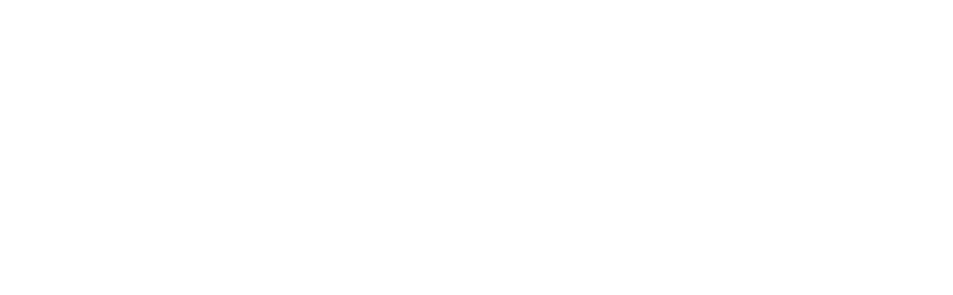

In [25]:
fig = plt.figure()
cam = Camera(fig)
plt.xlim([-1,4])  
plt.axis('off')
bins = np.linspace(-1,4,7)    
centers = bins[:-1] + np.diff(bins) / 2.0
grid = np.linspace(-1,4,500)
mu_range = np.linspace(1,2,100)
data = np.random.normal(size=100)
truths = sts.norm(loc=mu_range.reshape(-1,1)).pdf(grid)
for i,mu in enumerate(mu_range):   
    plt.plot(grid,truths[i], color='C1')                             # plot true data distribution
    plt.hist(data+mu,bins=bins,density=True, color='C0', alpha=0.6) # histogram data
    plt.axvline(mu, color='slategray', linestyle=':', alpha=0.6)
    cam.snap()
animation = cam.animate()
HTML(animation.to_html5_video())

## Making physics differentiable: <span style="color:blue">histograms</span>

An alternative: <span style="color:indigo">kernel density estimation</span>

$$\mathsf{kde}(x ; h, \mathsf{data}) = \mathsf{mean}_{i\,\in\,\mathsf{len(data)}}\left[K\left(\frac{x-\mathsf{data}[i]}{h}\right)\right]\times \frac{1}{h}$$

given some point $x$, kernel function $K$, and bandwith $h$ (smoothing parameter).

Normally (ahem), we use the *standard normal distribution* for $K$ 

$$\Rightarrow \mathsf{kde}(x ; h) = \mathsf{mean}_{i\,\in\,\mathsf{len(data)}}[\mathsf{Normal}(\mu_i = \mathsf{data}_{i}, \sigma_i = h )(x)]$$ 


**This is just an average of gaussians centered at each data point!** We control their widths *globally* using the bandwidth (one size fits all).

## Making physics differentiable: <span style="color:blue">histograms</span>



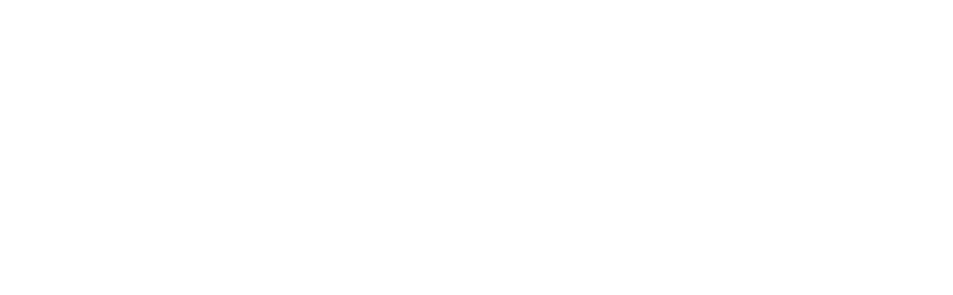

In [23]:
bw = 0.6
fig = plt.figure()
cam = Camera(fig)
plt.xlim([-1,4])  
plt.axis('off')
for i,mu in enumerate(mu_range):   
    plt.plot(grid,truths[i], color='C1') 
    plt.plot(grid,kde(grid,data+mu,h = bw),color='C9',linestyle=':')
    plt.bar(centers,
            kde_hist(data+mu,bins=bins,bandwidth=bw,density=True), 
            color='C9', 
            width = 5/(len(bins) - 1),
            alpha=0.6) # histogram data
    plt.axvline(mu, color='slategray', linestyle=':', alpha=0.6)
    cam.snap()
animation = cam.animate()
# animation.save('ani.gif',writer='imagemagick')

HTML(animation.to_html5_video())